<a href="https://colab.research.google.com/github/taitip-supha/BADS7105_CRM/blob/main/Test/Creaditcard_ML_VS_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (RUN) Seting Import package and Parameter

ref : 

In [1]:
#Set Environment and Parameter
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score ,f1_score ,precision_score ,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

import time

pd.set_option('display.max_columns', 100)



RANDOM_STATE = 2018
PREDS_RATIO = 0.5

# Prepar Data

## Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/creditcard.csv")
data_df.head(3)
print(f"Size od data frame {data_df.shape}")

Size od data frame (284807, 31)


In [4]:
#Define predictors and target values
target = 'Class'
predictors = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10','V11', 'V12', 'V13', 'V14', 'V15',
                   'V16', 'V17', 'V18', 'V19','V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [5]:
df_x = data_df[predictors]
df_y = data_df[target]

## Scaling predictors

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x = pd.DataFrame(scaler.fit_transform(df_x))

## Split data in train, test

In [7]:
TEST_SIZE = 0.20 # test size using_train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
print(f"Proportion of Target: {y_train.mean()}")

Proportion of Target: 0.0017204678619236761


## Oversampling Trainig Set

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = RANDOM_STATE ,sampling_strategy='minority')
x_train, y_train = smote.fit_resample(x_train,y_train)
print(f"Proportion after oversampling : {y_train.mean()}")

Proportion after oversampling : 0.5


## Prepare Data in Numpy

In [9]:
#Predictor
x_train = x_train.values.astype(np.float32)
x_test  = x_test.values.astype(np.float32)
print( f" x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):0.4f}, max(x_train)={np.max(x_train):0.4f}")
print( f" x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):0.4f}, max(x_test)={np.max(x_test):0.4f}")

 x_train.shape=(454906, 29), x_train.dtype=float32, min(x_train)=0.0000, max(x_train)=1.0000
 x_test.shape=(56962, 29), x_test.dtype=float32, min(x_test)=0.0000, max(x_test)=1.0000


In [10]:
#Target
y_train = y_train.values
y_test = y_test.values
print( f" y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train)}, max(y_train)={np.max(y_train)}")
print( f" y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test)}, max(y_test)={np.max(y_test)}")

 y_train.shape=(454906,), y_train.dtype=int64, min(y_train)=0, max(y_train)=1
 y_test.shape=(56962,), y_test.dtype=int64, min(y_test)=0, max(y_test)=1


# XGBoost

In [ ]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [ ]:
#Run Model
start_tm = time.time()
model_xgboost = xgb.train(params, 
                dtrain, 
                500,  #iterations
                watchlist, 
                early_stopping_rounds=50, 
                maximize=True, 
                verbose_eval=50  ) #Print out metric result
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")

[0]	train-auc:0.95904
Will train until train-auc hasn't improved in 50 rounds.
[50]	train-auc:0.985495
[100]	train-auc:0.991051
[150]	train-auc:0.99375
[200]	train-auc:0.995382
[250]	train-auc:0.996422
[300]	train-auc:0.997128
[350]	train-auc:0.997722
[400]	train-auc:0.998215
[450]	train-auc:0.998543
[499]	train-auc:0.998806
>>>>> Training Time >>>> 427.38291597366333 seconds


In [ ]:
preds_xgboost = model_xgboost.predict(dtest)

In [ ]:
roc_auc_score(y_test, preds_xgboost)

0.9684169568428826

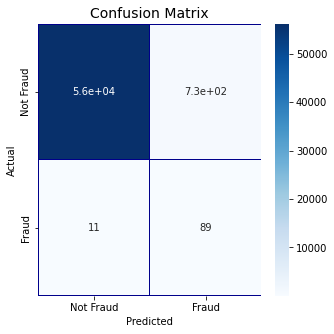

In [ ]:
cm = pd.crosstab(y_test, np.where(preds_xgboost>PREDS_RATIO,1,0), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# LightGBM

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [ ]:
#Prepare Model
dtrain = lgb.Dataset(x_train,
                     label=y_train,
                     feature_name=predictors)

In [ ]:
#Run Model
start_tm = time.time()
evals_results = {}
model_lgbm = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain],
                  valid_names=['train'],  
                  evals_result=evals_results, 
                  num_boost_round=500, #iterations
                  early_stopping_rounds=2*50,
                  verbose_eval=50, 
                  feval=None)
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")


Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.991914
[100]	train's auc: 0.997569
[150]	train's auc: 0.998673
[200]	train's auc: 0.999285
[250]	train's auc: 0.999597
[300]	train's auc: 0.999706
[350]	train's auc: 0.999766
[400]	train's auc: 0.999805
[450]	train's auc: 0.99986
[500]	train's auc: 0.999875
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.999875
>>>>> Training Time >>>> 53.72783875465393 seconds


In [ ]:
preds_lgbm = model_lgbm.predict(x_test)

In [ ]:
roc_auc_score(y_test, preds_lgbm)

0.972923393478949

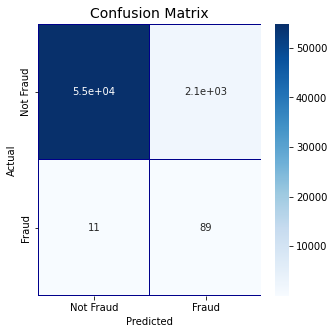

In [ ]:
cm = pd.crosstab(y_test, np.where(preds_lgbm>0.5,1,0), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Random Forest Classifier

In [ ]:
#Define model parameters
clf = RandomForestClassifier( random_state=RANDOM_STATE,
                             criterion='gini', #metric used for RandomForrestClassifier
                             n_estimators=100,  #number of estimators used for RandomForrestClassifier
                             verbose=False)

In [ ]:
#Run Model
start_tm = time.time()
clf.fit(x_train, y_train)
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")

>>>>> Training Time >>>> 538.4913191795349 seconds


In [ ]:
preds_clf = clf.predict(x_test)


In [ ]:
roc_auc_score(y_test.values, preds_clf)

0.9148593085012837

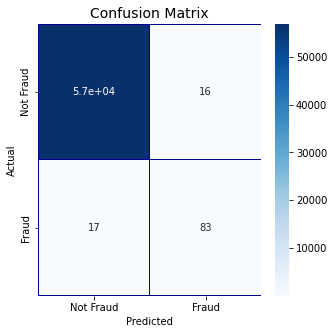

In [ ]:
cm = pd.crosstab(y_test, preds_clf, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Deep Learning MLP

## setting MPL Enviroment

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-417756ed-8086-11b7-1573-2ec5a617f3c7)


In [ ]:
import sys
import tensorflow as tf

In [ ]:
print(f"Python :{sys.version}\nNumpy:{np.__version__}\nTensorFlow{tf.__version__}")
print(f"tf.keras.backend.image_data_firmat() = {tf.keras.backend.image_data_format()}")
#Count the number ofGPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow detect {len(gpus)} GPUs")
for i,gpu in enumerate(gpus):
  print(f"> GPU No. {i} : Name = {gpu.name}  ,Type = {gpu.device_type}")

Python :3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Numpy:1.19.5
TensorFlow2.7.0
tf.keras.backend.image_data_firmat() = channels_last
TensorFlow detect 1 GPUs
> GPU No. 0 : Name = /physical_device:GPU:0  ,Type = GPU


In [ ]:
#seting
np.random.seed(1234)
tf.random.set_seed(5678)
_,input_dim = x_train.shape #the number of features per one input
output_din = len(set(y_train)) #the number of output classes

## Create the network architecture

In [ ]:
model = tf.keras.models.Sequential()

#Input layer
model.add(tf.keras.Input(shape=(input_dim,)))

#Hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu', name='hidden1')) #use defult weight initialization, don't use any regularization
model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))

#output layer
model.add(tf.keras.layers.Dense(output_din, activation='softmax', name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 32)                960       
                                                                 
 bn1 (BatchNormalization)    (None, 32)                128       
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 1,154
Trainable params: 1,090
Non-trainable params: 64
_________________________________________________________________


## Compile the model

In [ ]:
#Examples of compiling the model (only run one cell provided below)
#1) complie with default values for both optimizer and loss
# model.compile( optimizer='adam', loss='sparse_categorical_croseentropy', metrics=['acc'])
#2) complie + Hyperparameter tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])

## Training the model

In [ ]:
start_tm = time.time()
checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                               save_weights_only=True, 
                                                               monitor='val_acc', 
                                                               model='max', 
                                                               save_best_only=True)
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2, callbacks=[model_checkpoint_callback])
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")

Epoch 1/20
2844/2844 [==============================] - 18s 6ms/step - loss: 0.1133 - acc: 0.9544 - val_loss: 0.2828 - val_acc: 0.8649
Epoch 2/20
2844/2844 [==============================] - 15s 5ms/step - loss: 0.1029 - acc: 0.9575 - val_loss: 0.2783 - val_acc: 0.8917
Epoch 3/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0965 - acc: 0.9596 - val_loss: 0.2939 - val_acc: 0.8824
Epoch 4/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0925 - acc: 0.9616 - val_loss: 0.0748 - val_acc: 0.9660
Epoch 5/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0877 - acc: 0.9637 - val_loss: 0.1539 - val_acc: 0.9230
Epoch 6/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0828 - acc: 0.9655 - val_loss: 0.1312 - val_acc: 0.9304
Epoch 7/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0804 - acc: 0.9668 - val_loss: 0.0326 - val_acc: 0.9924
Epoch 8/20
2844/2844 [==============================] -

In [ ]:
#Inspect the save file (sorted by modification date,  newest first)
!ls -lt

total 200
-rw-r--r-- 1 root root 21056 Jan 26 13:43 bestmodel_epoch19_valloss0.00.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:43 bestmodel_epoch18_valloss0.01.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:43 bestmodel_epoch17_valloss0.02.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:41 bestmodel_epoch09_valloss0.02.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:40 bestmodel_epoch07_valloss0.03.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:40 bestmodel_epoch04_valloss0.07.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:39 bestmodel_epoch02_valloss0.28.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:39 bestmodel_epoch01_valloss0.28.hdf5
drwx------ 6 root root  4096 Jan 26 13:25 drive
drwxr-xr-x 1 root root  4096 Jan  7 14:33 sample_data


## Model Performance

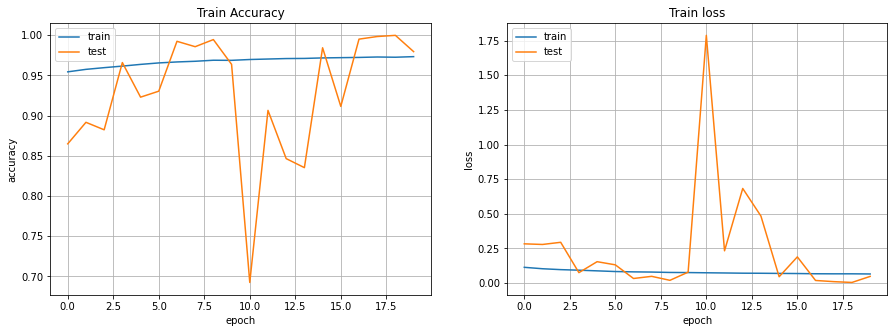

In [ ]:
#summary history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'] ,loc='upper left')
plt.grid()

#summary history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'] ,loc='upper left')
plt.grid()
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print(f"{model.metrics_names} = {results}")

446/446 [==============================] - 1s 3ms/step - loss: 0.0893 - acc: 0.9667
['loss', 'acc'] = [0.0893029198050499, 0.9666619896888733]


In [ ]:
preds_mlp = model.predict(x_test)

In [ ]:
pfm_auc = roc_auc_score(y_test, preds_mlp[:,1])
pfm_f1 = f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_precision = precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_recall = recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
print(f"AUC:{pfm_auc}\nF1 Score:{pfm_f1}\nPrecision:{pfm_precision}\nRecall:{pfm_recall}")

AUC:0.9710373360064719
F1 Score:0.9814461515184617
Precision:0.9981237714256764
Recall:0.9666619851831045


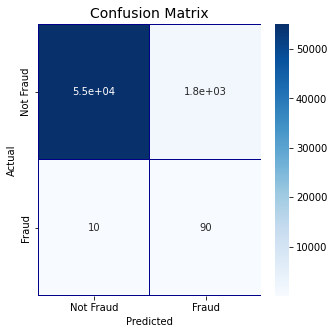

In [ ]:
cm = pd.crosstab(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Loop Training DP-MLP

In [11]:
import sys
import tensorflow as tf
#seting
np.random.seed(1234)
tf.random.set_seed(5678)
_,input_dim = x_train.shape #the number of features per one input
output_din = len(set(y_train)) #the number of output classes

In [ ]:
  # if output_layer_act.lower() == 'sigmoid':
  #   model.add(tf.keras.layers.Dense(1, activation='sigmoid' , name='output'))
  # elif output_layer_act.lower() == 'softmax':
  #   model.add(tf.keras.layers.Dense(2, activation='softmax' , name='output'))
  # else :
  #   print('Error Output Activation function')

In [13]:
def mlp_training(batchSize,epochNum,learnRate,optzer,output_layer_act = 'softmax',node=1):
  model = tf.keras.models.Sequential()
  #Input layer
  model.add(tf.keras.Input(shape=(input_dim,)))
  #Hidden 1 layer
  model.add(tf.keras.layers.Dense(node, activation='relu', name='hidden1')) #use defult weight initialization, don't use any regularization
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))
  #Hidden 2 layer
  model.add(tf.keras.layers.Dense(node, activation='relu', name='hidden1')) #use defult weight initialization, don't use any regularization
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))  
  #Hidden 3 layer
  model.add(tf.keras.layers.Dense(node, activation='relu', name='hidden1')) #use defult weight initialization, don't use any regularization
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))  

  #output layer
  model.add(tf.keras.layers.Dense(2, activation='softmax' , name='output'))

  #Compiling the model
  if optzer.lower() == 'adum':
    opt = tf.keras.optimizers.Adam(learning_rate=learnRate)
  elif optzer.lower() == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learnRate)
  else :
    print('error optimizers')
  model.compile(optimizer=opt
                      , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                      , metrics=['acc'])
  #Training
  history = model.fit(x_train, y_train, batch_size=batchSize, epochs=epochNum, verbose=0, validation_split=0.2)
  return model,history

In [14]:
start_tm = time.time()
model,history = mlp_training(256,5,0.01,'adum','sigmoid')
training_tm = time.time() - start_tm

In [15]:
model.summary()
preds_mlp = model.predict(x_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 32)                960       
                                                                 
 bn1 (BatchNormalization)    (None, 32)                128       
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 1,154
Trainable params: 1,090
Non-trainable params: 64
_________________________________________________________________


In [16]:
preds_mlp = model.predict(x_test)
pfm_auc = roc_auc_score(y_test, preds_mlp[:,1])
pfm_f1 = f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_precision = precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_recall = recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
print(f"AUC:{pfm_auc}\nF1 Score:{pfm_f1}\nPrecision:{pfm_precision}\nRecall:{pfm_recall}")

AUC:0.9751582779360557
F1 Score:0.9653357653494405
Precision:0.9981570169957226
Recall:0.9361153049401355


In [17]:
#list of Parameter
lst_batch = [256, 512, 1024]
lst_epoch = [5, 10, 15]
lst_learn = [0.001 ,0.005]
lst_opt = ['adum' ,'sgd']
lst_node = [1,28,56]
# lst_outact = ['sigmoid ', 'softmax']

In [ ]:
#Save Result
result_time = []
result_batch = []
result_epoch = []
result_learn = []
result_opt = []
result_auc = []
result_F1 = []
result_p = []
result_r= []
result_loss = []
result_acc = []

start_tm = time.time()
for batch_i in lst_batch:
  for epoch_j in lst_epoch:
    for learn_k in lst_learn:
      for opt_l in lst_opt:
        inloop_tm = time.time()
        model,history = mlp_training(batch_i,epoch_j,learn_k,opt_l,output_atc,node)
        result_time.append(time.time() - inloop_tm)
        preds_mlp = model.predict(x_test)
        #Save
        results = model.evaluate(x_test, y_test, batch_size=128 , verbose=0)
        result_batch.append(batch_i)
        result_epoch.append(epoch_j)
        result_learn.append(learn_k)
        result_opt.append(opt_l)
        result_auc.append(roc_auc_score(y_test, preds_mlp[:,1]))
        result_F1.append(f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted'))
        result_p.append(precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted'))
        result_r.append(recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted'))
        result_loss.append(results[0])
        result_acc.append(results[1])
print(f"Total runing loop : {time.time() - start_tm}")

In [ ]:
df_result_MLP = pd.DataFrame({'batch_size':result_batch
                              ,'epoch':result_epoch
                              ,'learning_rate':result_learn
                              ,'runing_times':result_time
                              ,'auc':result_auc
                              ,'f1score':result_F1
                              ,'precision':result_p
                              ,'recall':result_r
                              ,'loss':result_loss
                              ,'acc':result_acc
                              })
print(f"Size of table {df_result_MLP.shape} ")
df_result_MLP.to_csv("/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/creditcard_result.csv")
df_result_MLP.head()

Size of table (36, 10) 


,batch_size,epoch,learning_rate,runing_times,auc,f1score,precision,recall,loss,acc
0,256,5,0.001,19.879688,0.976428,0.996086,0.998446,0.994435,0.024212,0.994435
1,256,5,0.001,20.952582,0.974493,0.994287,0.998261,0.991222,0.082760,0.991222
2,256,5,0.005,19.635629,0.975157,0.935310,0.998169,0.881500,0.341200,0.881500
3,256,5,0.005,19.387591,0.975220,0.991047,0.998256,0.985095,0.078721,0.985095
4,256,10,0.001,38.798591,0.967603,0.972510,0.998170,0.949616,0.169059,0.949616
